In [ ]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

## Installations and imports

In [ ]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [ ]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

Cloning into 'my_repo'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 290 (delta 1), reused 7 (delta 1), pack-reused 280
Receiving objects: 100% (290/290), 13.05 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/my_repo
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 8.6 MB/s eta 0:00:00


### Import of the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from utils import util_data

kaggle.json not found, you cannot use kaggle module.


## Load the dataset

Laod the processed dataset from the repository.

In [ ]:
df_train = pd.read_csv("data/model/gsm_train.csv")
df_test = pd.read_csv("data/model/gsm_test.csv")

df_train.head(3)

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,1.0,0.000000,0.896591,-0.759706,0.000000,0.411819,0.572431,0,1,0,1,0,0,0,0,1.0,0.0,0.0,2.0
1,1.0,-0.349620,-0.270677,0.589274,0.681825,0.000000,1.196205,0,1,0,1,0,0,0,0,1.0,0.0,0.0,2.0
2,1.0,-0.592228,-0.762559,-1.830451,-1.306845,0.000000,0.000000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0


The dataset doesn't contain duplicates, and it is already preprocessed.

In [ ]:
# Show duplicated rows
def get_dup_rows(df, drop_cols):
    dup_rows = df[df.duplicated(subset=df.columns.drop(drop_cols), keep=False)]
    return dup_rows

get_dup_rows(df_train, ["misc_price"])

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution


The dataset doesn't contain null values. The total number of rows is 2205.

In [ ]:
print(f"Null values:{df_train.isna().sum().sum()}")
print(f"Number of duplicated rows: {df_train.duplicated().sum()}")
print(f"Number of rows: {df_train.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1757


In [ ]:
util_data.count_frequency_labels(df_train.misc_price).sort_index()

,Frequency,Count
0.0,24.59%,432
1.0,30.45%,535
2.0,28.00%,492
3.0,16.96%,298


### Train test split for the model

In [ ]:
print(f"Train dataset: {df_train.shape}, Test dataset: {df_test.shape}")

Train dataset: (1757, 19), Test dataset: (440, 19)


In [ ]:
X_train, y_train = df_train.drop("misc_price", axis=1), df_train.misc_price
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

In [ ]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (1405, 18), X_val: (352, 18), y_train: (1405,), y_val: (352,)


## Models

### Neural network

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchsummary

import math

from utils import util_models 
from utils import util_plot 

In [ ]:
EPOCHS = 70
BATCH_SIZE = 256
LR = 0.001
N_SPLITS = 5
SEED = 42

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_features = X_train.shape[1]
hidden_layers = [64, 256, 64]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=4).to(device)
torchsummary.summary(nn_model, (BATCH_SIZE, num_features));

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256, 64]             1,216
├─ReLU: 1-2                              [-1, 256, 64]             --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 256, 256]            16,640
├─ReLU: 1-3                              [-1, 256, 256]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-2                       [-1, 256, 64]             16,448
├─ReLU: 1-4                              [-1, 256, 64]             --
├─Linear: 1-5                            [-1, 256, 4]              260
Total params: 34,564
Trainable params: 34,564
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.02
Forward/backward pass size (MB): 0.76
Params size (MB): 0.13
Estimated Total Size (MB): 0.91


In [ ]:
test_data = util_models.TestData(X_test.values)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#### Holdout

In [ ]:
train_data = util_models.TrainData(X_train.values, y_train.values)
val_data = util_models.TrainData(X_val.values, y_val.values)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

In [ ]:
losses, accuracies = util_models.train_model(train_loader, val_loader, nn_model, device, LR, EPOCHS, print_every=1)

Epoch 001: | Loss: 1.36887 | Acc: 32.028 | Val loss: 1.33869 | Acc: 44.318
Epoch 002: | Loss: 1.31290 | Acc: 46.762 | Val loss: 1.27840 | Acc: 47.727
Epoch 003: | Loss: 1.24394 | Acc: 48.470 | Val loss: 1.20234 | Acc: 46.591
Epoch 004: | Loss: 1.16380 | Acc: 48.897 | Val loss: 1.13357 | Acc: 49.716
Epoch 005: | Loss: 1.08534 | Acc: 51.957 | Val loss: 1.06907 | Acc: 51.705
Epoch 006: | Loss: 1.02911 | Acc: 52.883 | Val loss: 1.03376 | Acc: 52.557
Epoch 007: | Loss: 1.01161 | Acc: 53.381 | Val loss: 1.00637 | Acc: 55.682
Epoch 008: | Loss: 1.00029 | Acc: 53.950 | Val loss: 0.99515 | Acc: 54.261
Epoch 009: | Loss: 0.97497 | Acc: 54.875 | Val loss: 0.97941 | Acc: 56.250
Epoch 010: | Loss: 0.96654 | Acc: 55.374 | Val loss: 0.96480 | Acc: 55.682
Epoch 011: | Loss: 0.95166 | Acc: 56.441 | Val loss: 0.97433 | Acc: 55.966
Epoch 012: | Loss: 0.93966 | Acc: 56.868 | Val loss: 0.95772 | Acc: 57.386
Epoch 013: | Loss: 0.94379 | Acc: 56.940 | Val loss: 0.96963 | Acc: 55.114
Epoch 014: | Loss: 0.9253

#### K-FOLD

In [ ]:
n_losses, n_accuracies = util_models.kfold_train_model(X_train.values, y_train.values,
                                                       N_SPLITS,SEED, BATCH_SIZE, nn_model,
                                                       device, LR, EPOCHS, print_every=5)

Epoch 005: | Loss: 1.03758 | Acc: 52.028 | Val loss: 1.06601 | Acc: 50.568
Epoch 010: | Loss: 0.88759 | Acc: 58.719 | Val loss: 1.01104 | Acc: 52.557
Epoch 015: | Loss: 0.86257 | Acc: 59.359 | Val loss: 0.98401 | Acc: 54.545
Epoch 020: | Loss: 0.83495 | Acc: 61.637 | Val loss: 0.97650 | Acc: 53.409
Epoch 025: | Loss: 0.82895 | Acc: 61.779 | Val loss: 0.97932 | Acc: 55.682
Epoch 030: | Loss: 0.81240 | Acc: 62.562 | Val loss: 0.98378 | Acc: 55.966
Epoch 035: | Loss: 0.77877 | Acc: 63.630 | Val loss: 0.97711 | Acc: 55.398
Epoch 040: | Loss: 0.76920 | Acc: 64.911 | Val loss: 0.98119 | Acc: 55.966
Epoch 045: | Loss: 0.74702 | Acc: 65.765 | Val loss: 0.98574 | Acc: 56.250
Epoch 050: | Loss: 0.74338 | Acc: 66.121 | Val loss: 1.00857 | Acc: 54.261
Epoch 055: | Loss: 0.73769 | Acc: 65.694 | Val loss: 1.01412 | Acc: 53.693
Epoch 060: | Loss: 0.70198 | Acc: 68.612 | Val loss: 1.03125 | Acc: 53.693
Epoch 065: | Loss: 0.68100 | Acc: 68.754 | Val loss: 1.03318 | Acc: 55.114
Epoch 070: | Loss: 0.6591

C:\Users\andre\AppData\Local\Temp\ipykernel_3308\616765924.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


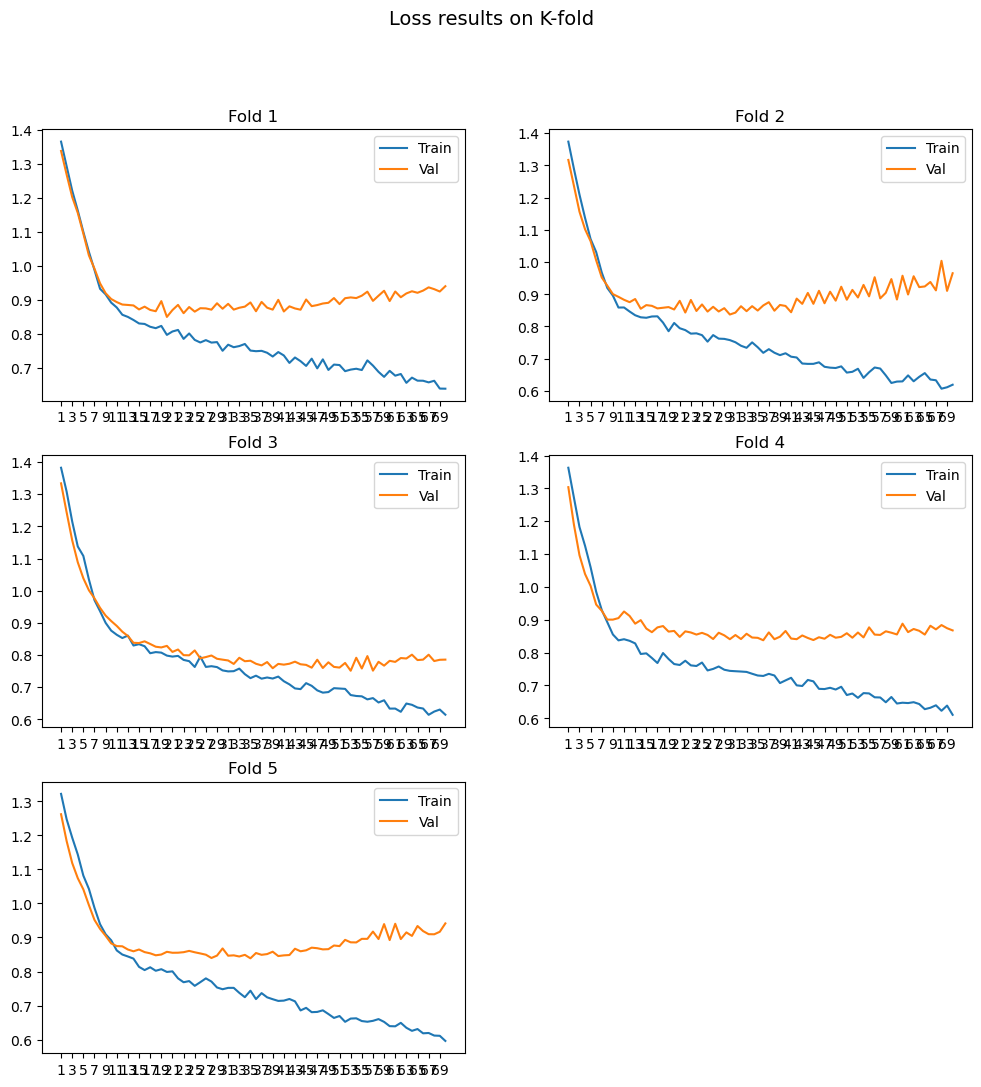

In [ ]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3308\998926134.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


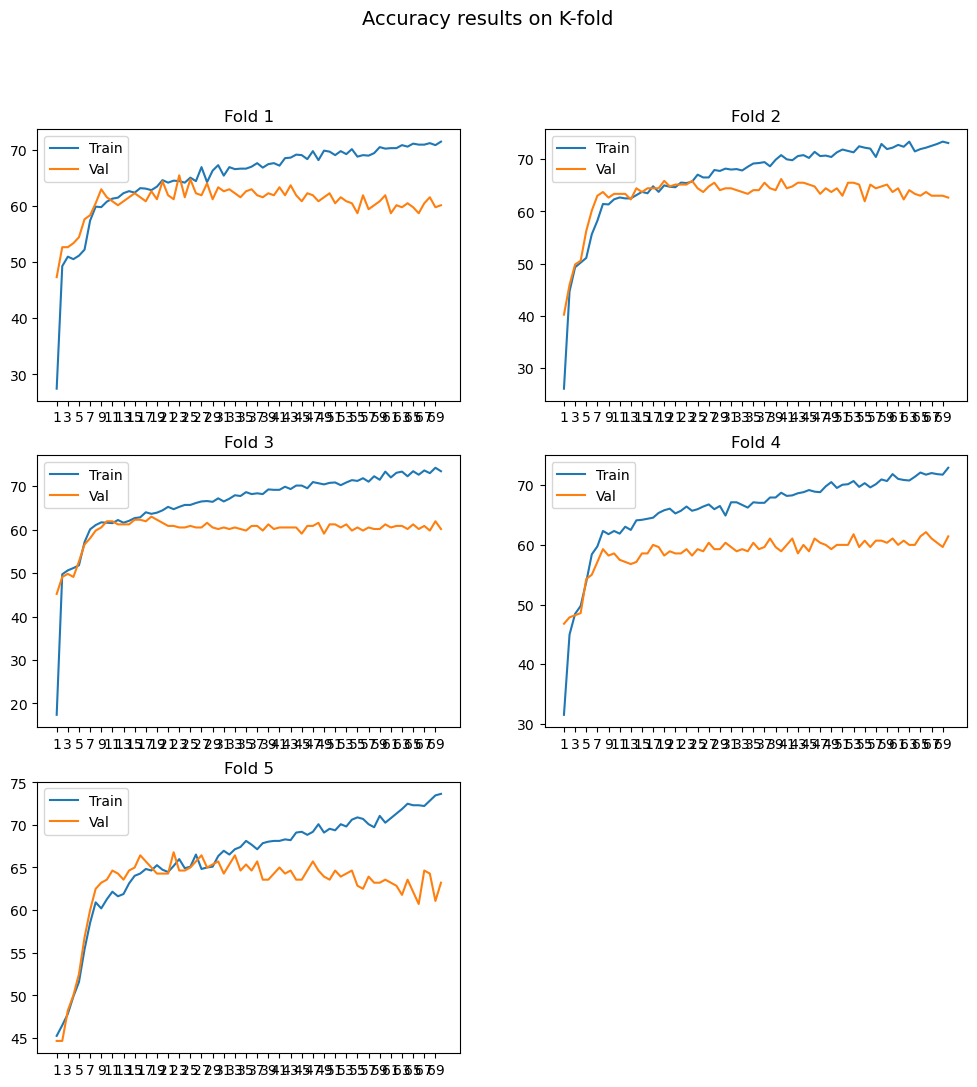

In [ ]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.show()

#### Test the model

In [ ]:
y_pred = util_models.test_model(test_loader, nn_model, device)

In [ ]:
print(f"Lenght of y_pred: {len(y_pred)}")
print(f"Lenght of y_test: {len(y_test)}")

Lenght of y_pred: 440
Lenght of y_test: 440


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test, y_pred, labels=[0,1,2,3], target_names=["low", "medium", "medium-high", "high"]))

              precision    recall  f1-score   support

         low       0.57      0.70      0.63       108
      medium       0.45      0.38      0.41       136
 medium-high       0.55      0.59      0.56       123
        high       0.74      0.59      0.66        73

    accuracy                           0.55       440
   macro avg       0.58      0.57      0.57       440
weighted avg       0.55      0.55      0.55       440



<Axes: >

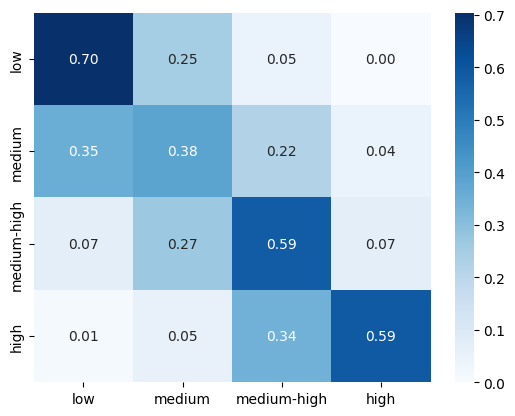

In [ ]:
# display confusion matrix with seaborn
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3], normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["low", "medium", "medium-high", "high"],
            yticklabels=["low", "medium", "medium-high", "high"])

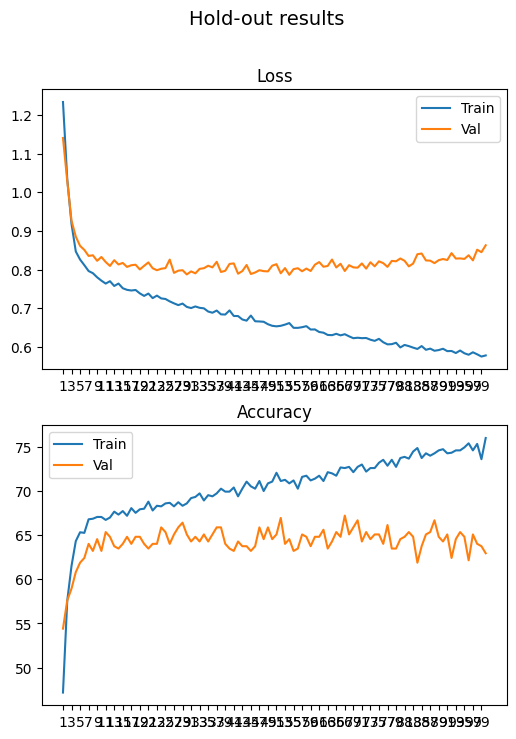

In [ ]:
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")

fig.show()

In [ ]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


y_preds = util_models.test_model(test_loader, nn_model, device)
accuracy = evaluate_predictions(y_test, y_preds)
print(f"Accuracy on test: {accuracy}")

Accuracy on test: 63.74622356495468


## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT

In [ ]:
import tempfile

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

import onnx

We need to declare the bounds for the variables that we are considering.

In [ ]:
x_test_np = X_test.values
y_test_np = y_test.values

In [ ]:
idx = 3
sample_idx = x_test_np[idx]
label_idx = y_test_np[idx]

#define dummy input tensor    
dummy_sample = torch.tensor(x_test_np[idx].reshape((1, -1))).type(torch.float)

# Define input region defined by infinity norm
# epsilon_infty = 5e-1
lb = np.repeat(-1, len(sample_idx))
# lb = np.maximum(-1, sample_idx - epsilon_infty)
ub = np.repeat(1, len(sample_idx))
# ub = np.minimum(1, sample_idx + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(x_test_np.shape[1]):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

In [ ]:
print(f"Label of sample {idx} is: {label_idx}")

Label of sample 3 is: 2.0


We also export the torch model to an onnx model using the relative function, then we build the formulation of the model that will be used by OMLT to create the optimization model.

In [ ]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    # Export neural network to ONNX
    torch.onnx.export(
        nn_model,
        dummy_sample,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    # Write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    # Load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
formulation = FullSpaceNNFormulation(network_definition)

We can now encode the neural network in a Pyomo model.

In [ ]:
# Create pyomo model
pyo_model = pyo.ConcreteModel()

# Create an OMLT block for the neural network and build its formulation
pyo_model.nn = OmltBlock()
pyo_model.nn.build_formulation(formulation) 

In [ ]:
#@title #### Compute the mean probability for the correctly predicted samples
#@markdown Since in the objective function we need to take a range of probabilities for computing
#@markdown the error (and we consider only correctly predicted samples for the counterfactual generation),
#@markdown we compute the mean and minimum value of the probabilities of the correct class.   
def count_correct_pred(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        correct_prob = []
        for ind in range(X_test.shape[0]):
            sample = torch.tensor(X_test.iloc[ind].tolist(), dtype=torch.float).view(1, -1)
            prob_pred = torch.softmax(model(sample), dim=1)

            max_prob = torch.argmax(prob_pred).item()
            if max_prob == y_test.values[ind]:
                correct_prob.append(prob_pred[0, max_prob])
    return torch.tensor(correct_prob)


correct_probs = count_correct_pred(nn_model, X_test, y_test)
print(f"The minimum probability for a correctly predicted sample is {torch.min(correct_probs):.3f}")
print(f"The mean probability for the correctly predicted samples is {torch.mean(correct_probs):.3f}")

The minimum probability for a correctly predicted sample is 0.385
The mean probability for the correctly predicted samples is 0.743


We looked for a multi-objective function and we found this interesting [paper](https://arxiv.org/pdf/2004.11165.pdf) in which the authors proposed different objectives to optimize.

TODO: check the upper bound we set, because 20 may be wrong given that we use the squared difference instead of the absolute value of the difference.

In [ ]:
#@title #### Functions to create objectives
def my_softmax(input, n_class, real_class):
    '''
        It returns the probability of the desired class after having computed the
        softmax for the input array.
    '''
    exps = [pyo.exp(input[i]) for i in range(n_class)]
    probs = []
    for exp in exps:
        res = exp/sum(exps)
        probs.append(res)
    return probs[real_class]


def features_constraints(pyo_model, feat_info):
    '''
        Set the bounds and the domain for each features given a dictionary that
        contains the bounds as a tuple, the domain as a pyomo domain and the position
        of the feature in the columns.
    '''
    for feat, info in feat_info.items():
        bounds = info["bounds"]
        domain = info["domain"]
        idx = info["index"]

        pyo_model.nn.inputs[idx].domain = domain
        pyo_model.nn.inputs[idx].bounds = bounds


def create_cat_constraints_obj_2(pyo_model, bounds, idx_cat, sample, feat_network):
    '''
        It creates the sum value for the categorical features of the second 
        objective function.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple(int)
                The lower and upper value for the constraints.
            - idx_cat: list[int]
                The indexes of the categorical features that we need to compare.
            - sample: np.ndarray
                The values for the categorical features of the original sample 
                for which the counterfactual is generated.
            - feat_network: list[int]
                The indexes of the connectivity features for which we need to add
                exclusive or constraints.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, len(idx_cat)))

    pyo_model.b_o2 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o2 = pyo.Var(feat_set, domain=pyo.Integers)
    pyo_model.constr_less_o2 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o2 = pyo.Constraint(feat_set)

    # Limit ohe features (network_connectivity)
    for idx in feat_network:
        pyo_model.nn.inputs[idx].domain = pyo.Binary

    pyo_model.xor_conn = pyo.Constraint()
    pyo_model.xor_conn = sum([pyo_model.nn.inputs[idx] for idx in feat_network]) == 1

    cat_dist = 0
    for i, idx in enumerate(idx_cat):
        pyo_model.diff_o2[i] = (sample[i] - pyo_model.nn.inputs[idx])**2

        pyo_model.constr_less_o2[i] = pyo_model.diff_o2[i] >= (pyo_model.b_o2[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o2[i] = pyo_model.diff_o2[i] <= (pyo_model.b_o2[i]*(U-1) + 1)+1
        cat_dist += pyo_model.b_o2[i]

    return cat_dist


def gower_distance(x, cat, num, ranges, pyo_model, feat_network, feat_info):
    '''
        It computes the Gower distance.

        Parameters: 
            - x: np.ndarray
                The array of features of the original sample.
            - cat: list[int]
                The indexes of the categorical features.
            - num: list[int]
                The indexes of the continuous features.
            - ranges: np.ndarray
                The list of ranges for the continuous features.
            - feat_network: list[int]
                The indexes of the positions of the network connectivity features
                to set exclusive or.
            - feat_info: dict
                It contains the information about the features to set the bounds
                and domain for each one.
    '''
    features_constraints(pyo_model, feat_info)

    num_dist = 0
    for i, idx in enumerate(num):
        num_dist += (1/ranges[i])*((x[idx]-pyo_model.nn.inputs[idx])**2)
    
    cat_dist = create_cat_constraints_obj_2(pyo_model, (0, 20), cat, x[cat], feat_network)

    return (cat_dist+num_dist)/len(x)


def compute_obj_3(pyo_model, bounds, n_feat, sample):
    '''
        It creates the third objective function, that limits the number of features
        changed during counterfactual.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple[int]
                The bounds to use for the constraints.
            - n_feat: int
                The number of features of the sample.
            - sample: np.ndarray
                The original sample for which the counterfactual is created.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, n_feat))

    pyo_model.b_o3 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o3 = pyo.Var(feat_set, domain=pyo.Reals)
    pyo_model.constr_less_o3 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o3 = pyo.Constraint(feat_set)

    changed = 0
    for i in range(n_feat):
        pyo_model.diff_o3[i] = (sample[i] - pyo_model.nn.inputs[i])**2

        pyo_model.constr_less_o3[i] = pyo_model.diff_o3[i] >= (pyo_model.b_o3[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o3[i] = pyo_model.diff_o3[i] <= (pyo_model.b_o3[i]*(U-1) + 1)+1
        changed += pyo_model.b_o3[i]

    return changed



def get_counterfactual_class(initial_class, num_classes, lower=True):
    """
        It returns the counterfactual class given the initial class, the number
        of classes and if the counterfactual needs to be lower or higher. The 
        function considers only counterfactuals that differs by 1 from the original
        class.
    """ 
    if initial_class >= num_classes or initial_class < 0:
        print("ERROR: the initial class has not a valid value.")
        return None
    initial_class = round(initial_class)
    idx_check = 0 if lower else num_classes - 1
    counterfactual_op = -1 if lower else 1
    if initial_class == idx_check:
        print("WARNING: the desired value was out of range, hence the opposite operation has been performed.")
        return initial_class - counterfactual_op
    return initial_class + counterfactual_op

We need to restrict the range of values that the categorical features can assume, we set the Integers domain for all the ones that are not binary and we use as bounds the maximum and minimum value of the feature.

In [ ]:
def create_feature_pyomo_data(X_test, num_cols):
    feat_info = {}
    binary_var = lambda x: 0 if "camera" in x else 1
    
    categorical_features = X_test.columns[~X_test.columns.isin(num_cols)]
    # Categorical features
    for col in categorical_features:
        feat_info[col] = {}
        if not binary_var(col):
            feat_info[col]["domain"] = pyo.Integers
            # Set the 2 extremes as bounds for the feature
            bounds = tuple(X_test[col].unique()[[0, -1]])
            feat_info[col]["bounds"] = bounds
        else:
            feat_info[col]["domain"] = pyo.Binary
            feat_info[col]["bounds"] = (0, 1)
        feat_info[col]["index"] = X_test.columns.tolist().index(col)

    return feat_info


num_cols = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
feat_info = create_feature_pyomo_data(X_test, num_cols)

In [ ]:
X_train.columns

Index(['display_size', 'battery', 'memory_ram_gb', 'memory_rom_gb',
       'main_camera_resolution', 'selfie_camera_resolution',
       'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers',
       'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging',
       'is_waterproof', 'network_technology', 'num_main_camera',
       'num_selfie_camera', 'display_resolution'],
      dtype='object')

In [ ]:
cf_class = get_counterfactual_class(label_idx, 4, lower=True)
print(f"Original label: {label_idx}")
print(f"Counterfactual label: {cf_class}")
original_sample = sample_idx

# OBJECTIVE 1
range_prob = 0.51
prob_y = lambda x: my_softmax(x, 4, cf_class)

# something
pyo_model.q_relu = pyo.Var(within=pyo.Binary)
# constraints
pyo_model._z_lower_bound_relu = pyo.Constraint()
pyo_model._z_lower_bound_zhat_relu = pyo.Constraint()
pyo_model._z_upper_bound_relu = pyo.Constraint()
pyo_model._z_upper_bound_zhat_relu = pyo.Constraint()

# set dummy parameters here to avoid warning message from Pyomo
pyo_model._big_m_lb_relu = pyo.Param(default=-1e6, mutable=True)
pyo_model._big_m_ub_relu = pyo.Param(default=1e6, mutable=True)

# define difference of the output
lb, ub = (-1, 1)
pyo_model.diff_prob = pyo.Var(within=pyo.Reals, bounds=(lb, ub), initialize=0)
pyo_model.diff_prob = range_prob - prob_y(pyo_model.nn.outputs)

# define variable for max(0, output)
pyo_model.max_val = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, ub))
pyo_model._big_m_lb_relu = lb
pyo_model._big_m_ub_relu = ub

pyo_model._z_lower_bound_relu = pyo_model.max_val >= 0
pyo_model._z_lower_bound_zhat_relu = pyo_model.max_val >= pyo_model.diff_prob
pyo_model._z_upper_bound_relu= pyo_model.max_val <= pyo_model._big_m_ub_relu * pyo_model.q_relu
pyo_model._z_upper_bound_zhat_relu = pyo_model.max_val <= pyo_model.diff_prob - pyo_model._big_m_lb_relu * (1.0 - pyo_model.q_relu)
#pyo_model.obj_1 = pyo.Objective(expr=pyo_model.max_val)

# ---------------------------------------------------------------- #
# OBJECTIVE 2
# Dataframe with continuous features only
num_df = X_test.loc[:, X_test.columns.isin(num_cols)]
cat_df = X_test.loc[:, ~X_test.columns.isin(num_cols)]
# We need the index of the features to differentiate in the gower distance
idx_cont = [X_test.columns.get_loc(col) for col in num_df.columns]
idx_cat = [X_test.columns.get_loc(col) for col in cat_df.columns]

cont_ranges = (num_df.max() - num_df.min()).values

gower_dist = gower_distance(original_sample, idx_cat, idx_cont, cont_ranges, 
                            pyo_model, [0, 1, 2], feat_info)

# ---------------------------------------------------------------- #

# OBJECTIVE 3
changed_feat_o3 = compute_obj_3(pyo_model, (0, 20), len(original_sample), original_sample)

# Set the objective for the counterfactual as the weighted sum of the three objective functions
pyo_model.obj = pyo.Objective(expr=pyo_model.max_val + 0.4*gower_dist + 0.6*changed_feat_o3)

Original label: 3.0
Counterfactual label: 2


Check what is the expression

In [ ]:
pyo_model.obj.expr.to_string()

'max_val + 0.4*((b_o2[0] + b_o2[1] + b_o2[2] + b_o2[3] + b_o2[4] + b_o2[5] + b_o2[6] + b_o2[7] + b_o2[8] + b_o2[9] + b_o2[10] + b_o2[11] + b_o2[12] + 0.18166679836149016*(1.0566250712265286 - nn.inputs[3])**2 + 0.20023831724820834*(0.5927006978252403 - nn.inputs[4])**2 + 0.2570608104484008*(2.083264950583299 - nn.inputs[5])**2 + 0.21235950364278594*(2.541999626593002 - nn.inputs[6])**2 + 0.10826805044126127*(0.3075974846588067 - nn.inputs[7])**2 + 0.10345063849534261*(0.8256930871634225 - nn.inputs[8])**2 + 0.12588287823187003*(-0.2929567236541104 - nn.inputs[9])**2 + 0.23784756658684886*(-0.06145494365670572 - nn.inputs[10])**2)/21) + 0.4*(b_o3[0] + b_o3[1] + b_o3[2] + b_o3[3] + b_o3[4] + b_o3[5] + b_o3[6] + b_o3[7] + b_o3[8] + b_o3[9] + b_o3[10] + b_o3[11] + b_o3[12] + b_o3[13] + b_o3[14] + b_o3[15] + b_o3[16] + b_o3[17] + b_o3[18] + b_o3[19] + b_o3[20])'

In [ ]:
#@title ### Download cplex from drive and install it
id_cplex_file = "1ePJy9nsNYfkvErFuedT6mbPmTfriQ2e8"
gdown.download(id=id_cplex_file, output="cplex_binary.bin", quiet=False)

# We can use /usr/bin/cplex as installation path when requested
!bash cplex_binary.bin

In [ ]:
# If we use as installation folder '/usr/bin'
pyo_solution = pyo.SolverFactory('cplex', executable='/usr/bin/cplex/bin/x86-64_linux/cplex').solve(pyo_model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmpc5oiccfl.cplex.log' open.
CPLEX> Problem '/tmp/tmp5wpk5v6z.pyomo.lp' read.
Read time = 0.01 sec. (0.15 ticks)
CPLEX> Problem name         : /tmp/tmp5wpk5v6z.pyomo.lp
Objective sense      : Minimize
Variables            :     535  [Nneg: 1,  Box: 316,  Free: 29,  Binary: 174,
                                 General Integer: 15,  Qobj: 8]
Objective nonzeros   :      44
Objective Q nonzeros :       8
Linear constraints   :     772  [Less: 455,  Greater: 129,  Equal: 188]
  Nonzeros           :    7108
  RHS nonzeros       :     297

Variables            : Min LB: -190.3791        Max UB:

In [ ]:
#@title ### Install cbc solver and run it
!apt-get install -y -qq coinor-cbc
pyo_solution = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(pyo_model, tee=True)

Extract the values of the found sample and test if the label is actually changed as desired.

In [ ]:
def evaluate_sample(model, sample_idx):
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        sample_idx = torch.tensor(sample_idx, dtype=torch.float).view(1, -1).to(device)
        # inference
        y_prob = torch.softmax(model(sample_idx), dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

    return y_pred.item()

y_pred_orig = evaluate_sample(nn_model, sample_idx)
counter_idx = list(pyo_model.nn.inputs.get_values().values())
y_pred_count = evaluate_sample(nn_model, counter_idx)

print(f"The predicted class for the original sample is {y_pred_orig}, while the predicted sample for the counterfactual is {y_pred_count}.")

The predicted class for the original sample is 3, while the predicted sample for the counterfactual is 2.


If we print the values of the original sample and the counterfactual we can see that the changes are in the allowed set of values.

In [ ]:
new_sample = pd.DataFrame(np.array(counter_idx, ndmin=2), columns=X_train.columns, index=["Counterfactual"])
orig_sample = pd.DataFrame(sample_idx.reshape(1, -1), columns=X_train.columns, index=["Orig sample"])
comp_df = pd.concat([new_sample, orig_sample], axis=0)
comp_df

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera
Counterfactual,0.0,0.0,1.0,1.000000,0.592701,1.000000,1.000,0.307597,0.825693,-0.292957,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Orig sample,0.0,1.0,0.0,1.056625,0.592701,2.083265,2.542,0.307597,0.825693,-0.292957,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0


### Dice

In [ ]:
from utils.util_models import DiceCounterfactual

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [ ]:
df_dice = pd.concat([X_train, y_train], axis=1)
df_dice.head()

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera,misc_price
1544,0.0,1.0,0.0,-0.369077,-0.486427,1.906789,1.449594,-0.422592,0.186784,-0.347239,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
876,0.0,1.0,0.0,0.839438,-0.118456,0.500206,0.653849,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1339,0.0,1.0,0.0,0.873967,0.776940,-0.906378,-0.619344,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0
1424,0.0,1.0,0.0,-0.455400,-0.486427,-0.906378,-0.778493,0.159890,0.186784,-0.417016,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
287,0.0,1.0,0.0,-0.455400,-0.977055,-0.906378,-0.778493,-0.713833,-0.791101,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


We initialize an instance of the class we created for dealing with Dice and generating counterfactuals.

In [ ]:
cont_features = list(df_dice.columns)
cont_features.remove('misc_price')

dice_cf = DiceCounterfactual(lgb_model.model, 'sklearn', df_dice, cont_features, target="misc_price")

In the first example we only choose one sample, that originally has label 3 (high price) and we want to produce a counterfactual that has label 2 to check which features we can change to decrease the price.

In [ ]:
idx = 40
count_class = 2

orig_sample = df_dice.iloc[[idx]]
orig_sample_lab = df_dice.iloc[[idx]]['misc_price']

We will use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [ ]:
dice_cf.create_explanation_instance(method="genetic")

cfs = dice_cf.generate_counterfactuals(orig_sample, new_class=count_class, target="misc_price", n_cf=2)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


We standardize the original samples and the counterfactuals to get real values for the devices.

In [ ]:
pairs = dice_cf.destandardize_cfs_orig(scaler_num=std_transf)

After that we got the sample - counterfactuals pairs we can pass them to a function in order to compare the differences in the features that allow to classify the sample as the desired class.

In [ ]:
compare_dfs = dice_cf.compare_sample_cf(pairs, color="red")

At the end we can print the comparison for all the samples for which we generated the counterfactuals simply retrieving the dataframe from the list.

In [ ]:
compare_dfs[0]

,Original sample,Counterfactual_0,Counterfactual_1
network_technology_3G,0.000,0.000,0.000
network_technology_4G,1.000,1.000,1.000
network_technology_5G,0.000,0.000,0.000
display_size,6.500,5.500,5.500
battery,3330.000,2730.000,3100.000
display_width,1644.000,1440.000,1440.000
display_height,3840.000,2560.000,960.000
memory_rom_gb,64.000,64.000,64.000
memory_ram_gb,6.000,6.000,6.000
main_camera_resolution,12.000,12.000,12.000


TODO
We can explore different interesting parameters in Dice:
- in 'generate_counterfactuals' function we can use:
    - proximity_weight, diversity_weight;
    - permitted_range, a dictionary with the feature names as keys and a list of the allowed values;
    - features_to_vary;